In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image
import numpy as np
import geopandas as gpd
import pandas as pd
import warnings
import time
%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams["figure.figsize"] = [5,5]
mpl.rcParams['lines.markersize'] = 5

Import custom functions from functions.py 

In [2]:
import functions

#### This notebook aims to streamline the exploritory work done in the 'Contour - Cumbria' notbook

Load in the gauges files<br>
(these have been filtered to only contain 2020 data and exported in QGIS)<br>
See "distance stations" notebook for more info on stations

In [3]:
daily_gauges = gpd.read_file("Contour Data/Daily-Gauges-UK.shp",crs=4326)
hourly_gauges = gpd.read_file("Contour Data/Hourly-Gauges-UK.shp",crs=4326)

#### Merge all hourly and dialy gauges still recording for the MET office in 2020

In [4]:
gauges = hourly_gauges.append(daily_gauges)

C:\Users\david\AppData\Local\Temp\ipykernel_14240\4224330975.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gauges = hourly_gauges.append(daily_gauges)


We have 368 gauges that were reporting in 2020

In [5]:
gauges.src_id.count()

368

# Start by showing the process step by step for one grid

load up list of 10x10km grids for a given grid of 100x100 km <br>
(loading takes a minute or so)

In [6]:
grid_id = "ny"
lst_points, lst_grid_point = functions.bulk_import_shapefiles(grid_id, 99,"point")
lst_lines, empty_list = functions.bulk_import_shapefiles(grid_id, 99,"line")

Now we have the data, need to match a gauge a grid.
- We want to make sure it creates a new column in the DF so we can use it later in the process as we need to look it up
- supply it with a list

In [7]:
gauges["grid_id"] = functions.select_closest_grid(gauges, lst_grid_point)

In [8]:
gauges.head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id
0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,POINT (-1.63000 59.52600),99


In [9]:
gauges["grid_id_distance"] = functions.select_closest_dist(gauges, lst_grid_point)

In [10]:
gauges.head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance
0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,POINT (-1.63000 59.52600),99,279096.477241


We only want gauges that are less than 5km away from the center of a grid:

In [11]:
gauges_in_cell = gauges.query("grid_id_distance < 5000")

In [12]:
gauges_in_cell.head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance
31,00289,KIELDER CASTLE,kielder-castle,northumberland,55.234,-2.58,201,2013,2020,POINT (-2.58000 55.23400),69,1741.523294


This is a little bit 'janky' as we might say, the priciple is that all the functions were written to take an index and then look that index up, and then apply it to that data.<br>
In hind sight might be better to supply a function with a row of a dataframe and then apply functions.<br>
For now i've left it and built a class: functions.slope_steepness which takes 'df, lst_lines, lst_points, selected_n' on initialisation.<br>
This then takes care of everyhting for you given you suply a df of gauges with id, a list of contours, a list of points and the number of contours to select

In [13]:
gauges_in_cell.reset_index(inplace=True)
gauges_in_cell.reset_index(inplace=True)
gauges_in_cell.head(3)

,level_0,index,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance
0,0,31,00289,KIELDER CASTLE,kielder-castle,northumberland,55.234,-2.580,201,2013,2020,POINT (-2.58000 55.23400),69,1741.523294
1,1,122,01023,ESKDALEMUIR,eskdalemuir,dumfriesshire,55.312,-3.207,236,1954,2020,POINT (-3.20700 55.31200),29,4763.902441
2,2,127,01060,KESWICK,keswick,cumbria,54.614,-3.157,81,1992,2020,POINT (-3.15700 54.61400),22,627.065674


Using the magic of functions (see functions.py) we can find the slope steepness

In [14]:
selected_n_contours = 10
gauges_in_cell["Slope_sorted"] = functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
                                            .by_distance_to_gauge()

In [15]:
gauges_in_cell.head(1)

,level_0,index,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_sorted
0,0,31,00289,KIELDER CASTLE,kielder-castle,northumberland,55.234,-2.58,201,2013,2020,POINT (-2.58000 55.23400),69,1741.523294,26.25


In [16]:
selected_n_contours = 10 # by default
gauges_in_cell["Slope_resorted"] = functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
                                            .by_closest_inter_distance()

In [17]:
gauges_in_cell.head(1)

,level_0,index,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_sorted,Slope_resorted
0,0,31,00289,KIELDER CASTLE,kielder-castle,northumberland,55.234,-2.58,201,2013,2020,POINT (-2.58000 55.23400),69,1741.523294,26.25,11.52


In [18]:
gauges_in_cell.to_csv(f"Output/{grid_id}.csv",
                            columns=["src_id","Slope_sorted","Slope_resorted"]) #,"Slope_sorted2","Slope_resorted2"])

# That was one grid, now lets repeat for all grids:
The UK consists of 55 grids:

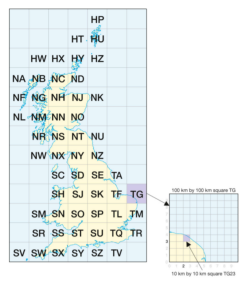

In [19]:
plt.imshow(matplotlib.image.imread("Plots/OS-Terrain50-Userguide.png"))
plt.axis("off");

Load all these names in. <br>
In the command promt "dir /b > filenames.txt" generates a list of all the filenames in that directory<br>
[more info on commandpromt](https://www.thewindowsclub.com/how-to-open-command-prompt-from-right-click-menu#:~:text=To%20open%20a%20command%20prompt%20window%20in%20any%20folder%2C%20simply,the%20same%20inside%20any%20folder)<br>


In [20]:
gridnames = []
with open("Final Data Output/gridnames.csv") as fin:
    for line in fin:
        gridnames.append(line.strip())

In [21]:
# gridnames

In [22]:
start = time.time()
run = False
if run:
    for i, grid_id in enumerate(gridnames):
        print(i,end="\r")
        
        lst_points, lst_grid_point = functions.bulk_import_shapefiles(grid_id, 99,"point")
        lst_lines, empty_list = functions.bulk_import_shapefiles(grid_id, 99,"line")
        
        gauges["grid_id"] = functions.select_closest_grid(gauges, lst_grid_point)
        gauges["grid_id_distance"] = functions.select_closest_dist(gauges, lst_grid_point)
        
        gauges_in_cell = gauges.query("grid_id_distance < 5000")
        
        gauges_in_cell.reset_index(inplace=True)
        gauges_in_cell.reset_index(inplace=True)
        
        selected_n_contours = 10 # by default
        
        gauges_in_cell["Slope_sorted"] = functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
                                            .by_distance_to_gauge()
        gauges_in_cell["Slope_resorted"] = functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
                                            .by_closest_inter_distance()
        
        gauges_in_cell.to_csv(f"Output/{grid_id}.csv",
                              columns=["src_id","Slope_sorted","Slope_resorted"]) #,"Slope_sorted2","Slope_resorted2"])

    end = time.time()
    print(f'{(end - start)/60:.3f} min')

last run:  16.171 min 

# Loading in run data:
in hindsight might have been better to store all in one file but this works too

In [23]:
i = "hx"

# col = [1,2,3,4,5]
col = [1,2,3]
base = pd.read_csv("Output/" + i + ".csv",index_col=0,usecols=col)
for i in gridnames:
    base = base.append(pd.read_csv("Output/" + i + ".csv",usecols=col))
    warnings.simplefilter("ignore")
    
gauges.src_id = gauges.src_id.astype(int)
base.src_id = base.src_id.astype(int)
# for i in ["Slope_resorted","Slope_sorted2","Slope_resorted2","Slope_sorted"]: 
#     base[i] = base[i].astype(float)

Need df to add the other to

In [24]:
base = base.sort_values("src_id")
base.head(1)

,Slope_resorted,src_id,Slope_sorted
0,27.24,3,43.44


merging the two together

In [39]:
combined = pd.merge(gauges, base,on="src_id")
# combined.to_csv("Final Data Output/206 stations with slope Data.csv")
combined.head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_resorted,Slope_sorted
0,3,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,POINT (-1.63000 59.52600),27,789.29992,27.24,43.44


In [26]:
combined.Slope_sorted.max(),combined.Slope_sorted.min(), combined.Slope_sorted.mean(),

(154.64, 2.38, 16.16909952606635)

Comparing sorted and resorted plots

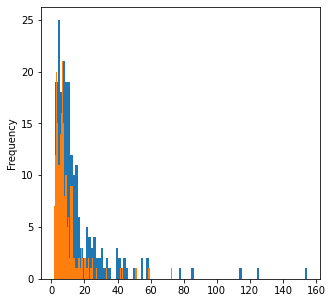

In [27]:
combined.Slope_sorted.plot.hist(bins=100)
combined.Slope_resorted.plot.hist(bins=100);

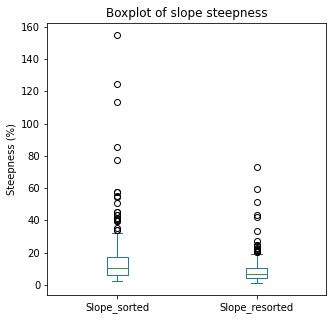

In [40]:
pd.DataFrame(combined, columns=["Slope_sorted","Slope_resorted"]).astype(float).plot.box()
plt.title("Boxplot of slope steepness")
plt.ylabel("Steepness (%)")
# plt.savefig("Plots/Slopesteepness Boxplot sorted vs resorted.jpg",pad_inches=0)

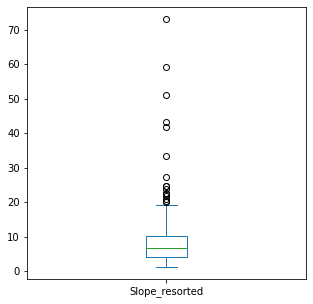

In [41]:
combined.Slope_resorted.plot.box()
# plt.savefig("Plots/Slopesteepness Boxplot resorted.jpg",pad_inches=0)

#### Saving queries for reprocessing

In [30]:
combined.query("Slope_resorted < 18.125").to_csv("Final Data Output/Removed outliers.csv")

In [31]:
combined.query("Slope_resorted < 18.125").head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_resorted,Slope_sorted
1,9,LERWICK,lerwick,shetland,60.139,-1.185,82,1930,2020,POINT (-1.18500 60.13900),99,322571.744968,8.32,11.57


In [32]:
combined.query("Slope_resorted > 18.125").to_csv("Final Data Output//outliers.csv")

In [33]:
combined.query("Slope_resorted > 18.125").head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_resorted,Slope_sorted
0,3,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,POINT (-1.63000 59.52600),99,279096.477241,27.24,43.44


# Looking at outliers

In [34]:
IQR = combined.Slope_resorted.quantile(q=0.75) - combined.Slope_resorted.quantile(q=0.25)
Outlier_threshold = combined.Slope_resorted.quantile(q=0.75) + 1.5 * IQR
print(Outlier_threshold)
outliers_resorted = combined.query(f"Slope_resorted > {Outlier_threshold}")
print(outliers_resorted.src_id .count())
# outliers_resorted.plot.scatter(outliers_resorted.station_el,outliers_resorted.Slope_resorted)

19.417499999999997
16


<AxesSubplot:>

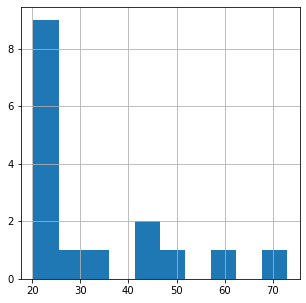

In [35]:
outliers_resorted.Slope_resorted.hist()

In [36]:
### recalculating for the fair isles (midterm figure)
grid_id = "hz"
run = True
if run:
    lst_points, lst_grid_point = functions.bulk_import_shapefiles(grid_id, 99,"point")
    lst_lines, empty_list = functions.bulk_import_shapefiles(grid_id, 99,"line")

    gauges["grid_id"] = functions.select_closest_grid(gauges, lst_grid_point)
    gauges["grid_id_distance"] = functions.select_closest_dist(gauges, lst_grid_point)

    gauges_in_cell = gauges.query("grid_id_distance < 5000")
    gauges_in_cell.reset_index(inplace=True)
    gauges_in_cell.reset_index(inplace=True)

    selected_n_contours = 10 # by default
    gauges_in_cell["Slope_resorted"] = functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
                                        .by_closest_inter_distance()


<AxesSubplot:>

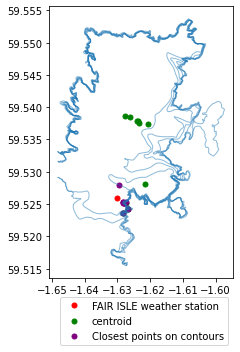

In [37]:
selected_n_contours= 10
functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
        .plot_closest_point_contours(0)
# plt.savefig("Plots/FairIsle weather station - 10 closest.jpg")

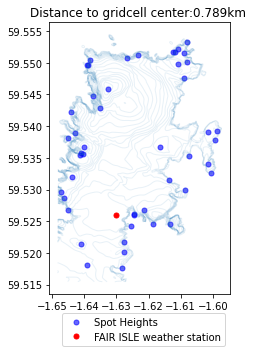

In [38]:
selected_n_contours= 10
functions.slope_steepness(gauges_in_cell, lst_lines, lst_points, selected_n_contours)\
        .plot_station(0)
# plt.savefig("Plots/FairIsle weather station - overview.jpg")